In [96]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets

In [97]:
if torch.cuda.is_available():
  DEVICE = torch.device('cuda')
else:
  DEVICE = torch.device('cpu')

print('Using PyTorch version:', torch.__version__, 'Device:', DEVICE)


Using PyTorch version: 1.9.0+cu102 Device: cuda


In [98]:
BATCH_SIZE = 32
EPOCHS = 10

In [99]:
train_dataset = datasets.CIFAR10(root = "../data/CIFAR_10",
                                 train = True,
                                 download = True,
                                 transform = transforms.ToTensor())

test_dataset = datasets.CIFAR10(root = "../data/CIFAR_10",
                                train = False,
                                transform = transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                           batch_size = BATCH_SIZE,
                                           shuffle = False)

test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                          batch_size = BATCH_SIZE,
                                          shuffle = False)

Files already downloaded and verified


In [100]:
for (X_train, y_train) in train_loader:
  print('X_train:', X_train.size(), 'type:', X_train.type())
  print('y_train:', y_train.size(), 'type:', y_train.type())
  break



X_train: torch.Size([32, 3, 32, 32]) type: torch.FloatTensor
y_train: torch.Size([32]) type: torch.LongTensor


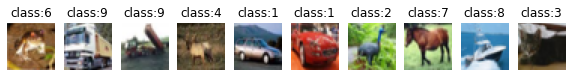

In [101]:
pltsize = 1
plt.figure(figsize = (10 * pltsize, pltsize))

for i in range(10):
  plt.subplot(1, 10, i+1)
  plt.axis('off')
  plt.imshow(np.transpose(X_train[i],(1,2,0)))
  plt.title('class:' + str(y_train[i].item()))

In [107]:
'''
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.fc1 = nn.Linear(32*32*3, 512)
    self.fc2 = nn.Linear(512, 256)
    self.fc3 = nn.Linear(256, 10)

  def forward(self, x):
    x = x.view(-1, 32*32*3)
    x = self.fc1(x)
    x = F.relu(x)
    x = self.fc2(x)
    x = F.relu(x)
    x = self.fc3(x)
    x = F.log_softmax(x, dim = 1)
    return x
    
'''

class CNN(nn.Module):
  def __init__(self):
    super(CNN, self).__init__()
    self.conv1 = nn.Conv2d(
        in_channels = 3,
        out_channels = 8,
        kernel_size = 3,
        padding = 1)
    self.conv2 = nn.Conv2d(
        in_channels = 8,
        out_channels = 16,
        kernel_size = 3,
        padding = 1)
    self.pool = nn.MaxPool2d(
        kernel_size = 2,
        stride = 2)

    self.fc1 = nn.Linear(8*8*16, 64)
    self.fc2 = nn.Linear(64, 32)
    self.fc3 = nn.Linear(32, 10)

  def forward(self, x):
    x = self.conv1(x)
    x = F.relu(x)
    x = self.pool(x)
    x = self.conv2(x)
    x = F.relu(x)
    x = self.pool(x)

    x = x.view(-1, 8*8*16)
    x = self.fc1(x)
    x = F.relu(x)
    x = self.fc2(x)
    x = F.relu(x)
    x = self.fc3(x)
    x = F.log_softmax(x)
    return x

# pooling? 특징 뽑아내는 과정, max pooling이 보통 쓰임 
# 왜 32*32 -> 2*2, stride 2인 상황에서 8*8로 바뀌는지 ?? 


In [108]:
model = CNN().to(DEVICE)

#model = Net().to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
criterion = nn.CrossEntropyLoss()

print(model)

CNN(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=10, bias=True)
)


In [109]:
def train(model, train_loader, optimizer, log_interval):
  model.train()
  for batch_idx,(image, label) in enumerate(train_loader):
    image = image.to(DEVICE)
    label = label.to(DEVICE)
    optimizer.zero_grad()
    output = model(image)
    loss = criterion(output, label)
    loss.backward()
    optimizer.step()

    if batch_idx % log_interval == 0:
      print("train Epoch: {} [{}/{}({:.0f}%)]\tTrain Loss: {:.6f}".format(
          Epoch, batch_idx*len(image),
          len(train_loader.dataset), 100. * batch_idx / len(train_loader),
          loss.item()
      ))

In [110]:
def evaluate(model, test_loader):
  model.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for image, label in test_loader:
      image = image.to(DEVICE)
      label = label.to(DEVICE)
      output = model(image)
      test_loss += criterion(output, label).item()
      prediction = output.max(1, keepdim = True)[1]
      correct += prediction.eq(label.view_as(prediction)).sum().item()
    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. *correct / len(test_loader.dataset)
    return test_loss, test_accuracy
      

In [ ]:
for Epoch in range(1, EPOCHS + 1):
  train(model, train_loader, optimizer, log_interval = 200)
  test_loss, test_accuracy = evaluate(model, test_loader)
  print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \t Test Accuracy: {:.2f} % \n".format(Epoch, test_loss, test_accuracy))
  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


train Epoch: 1 [0/50000(0%)]	Train Loss: 2.279749
train Epoch: 1 [6400/50000(13%)]	Train Loss: 1.904578
train Epoch: 1 [12800/50000(26%)]	Train Loss: 1.828383
train Epoch: 1 [19200/50000(38%)]	Train Loss: 1.988673
train Epoch: 1 [25600/50000(51%)]	Train Loss: 1.684059
train Epoch: 1 [32000/50000(64%)]	Train Loss: 1.685034
train Epoch: 1 [38400/50000(77%)]	Train Loss: 1.673117
train Epoch: 1 [44800/50000(90%)]	Train Loss: 1.518200

[EPOCH: 1], 	Test Loss: 0.0484, 	 Test Accuracy: 43.76 % 

train Epoch: 2 [0/50000(0%)]	Train Loss: 1.626849
train Epoch: 2 [6400/50000(13%)]	Train Loss: 1.335802
train Epoch: 2 [12800/50000(26%)]	Train Loss: 1.343271
train Epoch: 2 [19200/50000(38%)]	Train Loss: 1.615606
train Epoch: 2 [25600/50000(51%)]	Train Loss: 1.095548
train Epoch: 2 [32000/50000(64%)]	Train Loss: 1.511892
train Epoch: 2 [38400/50000(77%)]	Train Loss: 1.477235
train Epoch: 2 [44800/50000(90%)]	Train Loss: 1.557226

[EPOCH: 2], 	Test Loss: 0.0441, 	 Test Accuracy: 49.21 % 

train Epoch:

In [20]:
# 위에 MLP모델은 서로 지역적 특징을 반영할 수 없기 때문에, 새로운 CNN 생성해보자

class CNN(nn.Module):
  def __init__(self):
    super(CNN, self).__init__()
    self.conv1 = nn.Conv2d(
        in_channels = 3,
        out_channels = 8,
        kernel_size = 3,
        padding = 1)
    self.conv2 = nn.Conv2d(
        in_channels = 8,
        out_channels = 16,
        kernel_size = 3,
        padding = 1)
    self.pool = nn.MaxPool2d(
        kernel_size = 2,
        stride = 2)

    self.fc1 = nn.Linear(8*8*16, 64)
    self.fc2 = nn.Linear(64, 32)
    self.fc3 = nn.Linear(32, 10)

In [27]:

def forward(self, x):
  x = self.conv1(x)
  x = F.relu(x)
  x = self.pool(x)
  x = self.conv2(x)
  x = F.relu(x)
  x = self.pool(x)

  x = x.view(-1, 8*8*16)
  x = self.fc1(x)
  x = F.relu(x)
  x = self.fc2(x)
  x = F.relu(x)
  x = self.fc3(x)
  x = F.log_softmax(x)
  return x

# pooling? 특징 뽑아내는 과정, max pooling이 보통 쓰임 
